<a href="https://colab.research.google.com/github/Mkath1423/Mask-RCNN-Fusion-Experiments/blob/main/MaskRCNNFusionExperiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(1, "/content/drive/MyDrive/MaskRCNNFusionExperiments")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [56]:
import os

os.chdir("/content/drive/MyDrive/MaskRCNNFusionExperiment")
os.getcwd()

from datetime import datetime
from random import randint

import matplotlib.pyplot as plt
import torch
import torchvision
from torch import autocast, nn
from torch.nn import CrossEntropyLoss
from torch.optim import RMSprop
from torch.optim.lr_scheduler import ExponentialLR
from torch.optim.lr_scheduler import CosineAnnealingLR

from torch.utils.data import DataLoader

from utilities.config import LoadConfig, SaveConfig, TrainingConfig
from utilities.utilities import save_model_parameters, load_model_parameters

import numpy as np

import random

DEVICE = "cuda"
RUNCODE = random.randint(10000, 100000)


os.getcwd()

import warnings

warnings.filterwarnings("ignore")

In [57]:
device = "cuda"
if device == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Total: ',round(torch.cuda.get_device_properties(0).total_memory/1024**3,1), "GB")
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
    print("Summary: ", torch.cuda.memory_summary())
num_classes = 4
RUNCODE = 672788

Tesla P100-PCIE-16GB
Memory Usage:
Total:  15.9 GB
Allocated: 0.4 GB
Cached:    2.4 GB
Summary:  |===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  407109 KB |    2060 MB |  160432 GB |  160432 GB |
|       from large pool |  361448 KB |    1943 MB |  157874 GB |  157874 GB |
|       from small pool |   45661 KB |     142 MB |    2558 GB |    2558 GB |
|---------------------------------------------------------------------------|
| Active memory         |  407109 KB |    206

# Dataset and Dataloaders



config and load data 

In [58]:
# for this dataset
# tensor([3.5970e-01, 3.3571e-01, 3.1466e-01, 1.5642e+07])
# tensor([1.6452e-01, 1.6263e-01, 1.7999e-01, 8.5321e+07])

data_config = {
    "data_path": "./data/ApesAndShapes",
    "class_weight": [1159680,  122625,  173226,   80469],

    # "rgb_mean": [0.23500395, 0.16341497, 0.08677972],
    # "rgb_scale": [0.05813568, 0.04724738, 0.01910823],
    # "z_mean": 0.6483100016117096,
    # "z_scale": 0.25,
    
    "rgb_mean": [3.5970e-01, 3.3571e-01, 3.1466e-01,],
    "rgb_scale": [1.6452e-01, 1.6263e-01, 1.7999e-01],
    "z_mean": 0.6483100016117096,
    "z_scale": 0.25,

    "z_only": False,
    "percent_train": 80,
}

In [59]:
from dataloaders import ApesAndShapesDataset

dataset = ApesAndShapesDataset(data_config, data_path=data_config["data_path"])

found 255 data files
Transforms Configured:
RGB mean:  [0.3597  0.33571 0.31466]
RGB scale:  [0.16452 0.16263 0.17999]
Z mean:  0.6483100016117096
Z scale:  0.25


In [ ]:
# compute the weights
nSamples = torch.tensor([0 for i in range(num_classes)])
for data in dataset:
    nSamples += torch.bincount(data["class_segmap"].flatten().int())
    print(nSamples)

normedWeights = [1 - (x / sum(nSamples)) for x in nSamples]

data_config["class_weight"] = normedWeights
print(normedWeights)

In [ ]:
#compute mean and std

mean = torch.tensor([0., 0., 0., 0.])
std  = torch.tensor([0., 0., 0., 0.])

dataloader = DataLoader(dataset, batch_size=1)

for i, image in enumerate(dataloader):
  mean += image["x"].squeeze().mean((1, 2))
  std  += image["x"].squeeze().std((1, 2))

print(mean/len(dataset))
print(std/len(dataset))



In [ ]:
print(mean)
print(std)

tensor([3.5970e-01, 3.3571e-01, 3.1466e-01, 1.5642e+07])
tensor([1.6452e-01, 1.6263e-01, 1.7999e-01, 8.5321e+07])


verify dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


255


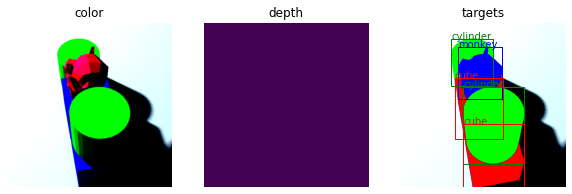

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


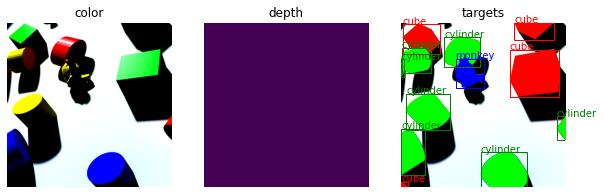

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


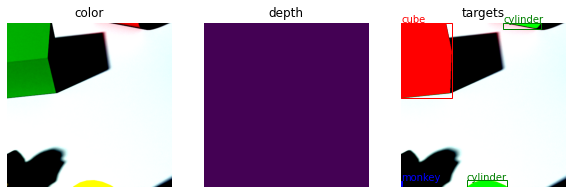

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


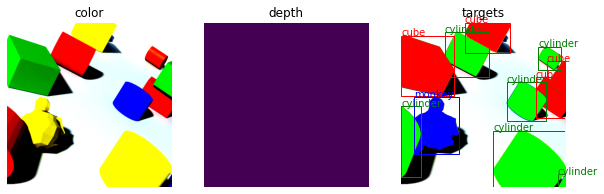

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


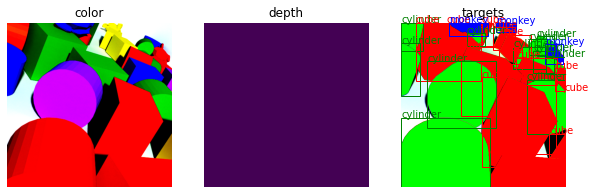

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


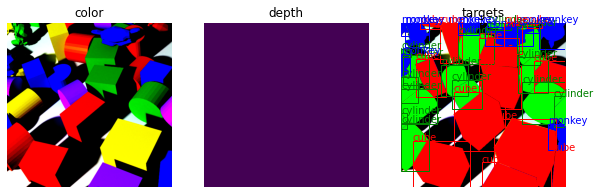

In [60]:
dataset_length = len(dataset)
print(dataset_length)

for i in range(0, dataset_length, 50):
  dataset.plot_sample(i)
    

make dataloaders

In [61]:
def train_test_split(dataset, percent_train=80):
    percent_train = int(percent_train)

    n_train = percent_train*len(dataset)//100

    if n_train <2 or n_train > (len(dataset)-2):
        return False, None, None

    dataset_train, dataset_test = torch.utils.data.random_split(dataset, [n_train,len(dataset)-n_train])
    print("train fraction: ", len(dataset_train)/len(dataset)*100)
    print("test fraction: ", len(dataset_test)/len(dataset)*100)

    return True, dataset_train, dataset_test

In [ ]:
# prep data
is_valid, train_data, test_data = train_test_split(dataset, percent_train=data_config["percent_train"])

if(is_valid):
  print(len(train_data), len(test_data))
  # make training objects
  train_dataloader = DataLoader(train_data, batch_size=2)
  test_dataloader  = DataLoader(test_data, batch_size=2)

train fraction:  80.0
test fraction:  20.0
204 51


# Models

In [62]:
from torchvision.models.detection.anchor_utils import AnchorGenerator
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

from models.backbones import ResNetEarlyFusion, ResNetLateFusion, ResNetMidFusion

In [63]:
def get_model_instance_segmentation(num_classes,
                                    backbone : nn.Module = ResNetEarlyFusion(4, 4)):
    # load an instance segmentation model pre-trained on COCO
    anchor_generator = AnchorGenerator(
        sizes=((32, 64, 128),),
        aspect_ratios=((0.5, 1.0, 2.0),))

    mask_rcnn = torchvision.models.detection.MaskRCNN(
        backbone=backbone,  # backbone
        num_classes=3,
        rpn_anchor_generator=anchor_generator,
        image_mean=[3.5970e-01, 3.3571e-01, 3.1466e-01, 0.6483100016117096],
        image_std=[1.6452e-01, 1.6263e-01, 1.7999e-01, 0.25]
    )

    # get number of input features for the classifier
    in_features = mask_rcnn.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    mask_rcnn.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = mask_rcnn.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    mask_rcnn.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                           hidden_layer,
                                                           num_classes)
    mask_rcnn.to(device=device)
    return mask_rcnn

In [65]:
# early fusion
model = get_model_instance_segmentation(num_classes, backbone=ResNetEarlyFusion(4, num_classes))

In [64]:
# mid fusion
model = get_model_instance_segmentation(num_classes, backbone=ResNetMidFusion(3, 1, num_classes))

In [ ]:
# late fusion
model = get_model_instance_segmentation(num_classes, backbone=ResNetLateFusion(3, 1, num_classes))

In [16]:
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# now get the number of input features for the mask classifier
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256
# and replace the mask predictor with a new one
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                    hidden_layer,
                                                    num_classes)

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


  0%|          | 0.00/170M [00:00<?, ?B/s]

In [ ]:
# load model parameters
optimizer = RMSprop(model.parameters(), lr=0.00001, momentum=0.8)

load_config = LoadConfig({'directory':'checkpoints', 
                          'folder':f"2022-05-22_63576", 
                          'name':'unnamed_model_71_1.2120413780212402'})

load_model_parameters(load_config, model, optimizer)

In [85]:
for p in model.parameters():
    
    print(f"{torch.flatten(p).size()[0] ==  p.count_nonzero().item()}", torch.flatten(p).size()[0], p.count_nonzero().item())

True 2304 2304
True 64 64
True 64 64
True 36864 36864
True 64 64
True 64 64
True 36864 36864
True 64 64
True 64 64
True 36864 36864
True 64 64
True 64 64
True 36864 36864
True 64 64
True 64 64
True 36864 36864
True 64 64
True 64 64
True 73728 73728
True 128 128
True 128 128
True 147456 147456
True 128 128
True 128 128
True 8192 8192
True 128 128
True 128 128
True 147456 147456
True 128 128
True 128 128
True 147456 147456
True 128 128
True 128 128
True 294912 294912
True 256 256
True 256 256
True 589824 589824
True 256 256
True 256 256
True 32768 32768
True 256 256
True 256 256
True 589824 589824
True 256 256
True 256 256
True 589824 589824
True 256 256
True 256 256
True 1179648 1179648
True 512 512
True 512 512
True 2359296 2359296
True 512 512
True 512 512
True 131072 131072
True 512 512
True 512 512
True 2359296 2359296
True 512 512
True 512 512
True 2359296 2359296
True 512 512
True 512 512
True 2048 2048
True 4 4
True 144 144
True 4 4
True 36 36
True 9 9
True 144 144
True 36 36
Tru

# Display

In [66]:
def display_model_prediction(model, x):
    with torch.no_grad():
        model.cuda()
        x = x.to(device=device)
        print(x.shape)
        model.eval()
        image = model([x])

        for k, v in image[0].items():
          print(f"{k}: {v.size()}")

        plot_pred(x.cpu(), 
                          image[0]["boxes"].cpu(), 
                          image[0]['labels'].cpu(), 
                          image[0]['scores'].cpu(), 
                          image[0]["masks"].cpu())

In [67]:

from matplotlib.patches import Rectangle

def plot_pred(color, boxes, labels, scores, masks):
    fig = plt.figure(figsize=(10, 30))
    sub = fig.add_subplot(1, 3, 1)
    plt.axis("off")
    sub.title.set_text("color")
    plt.imshow(color.permute(1, 2, 0))

    sub = fig.add_subplot(1, 3, 2)
    plt.axis("off")
    sub.title.set_text("targets")
    plt.imshow(color.permute(1, 2, 0))

    for box, label, score, mask in zip(boxes, labels, scores, masks):

        overlay = torch.vstack([dataset.class_color_bases[label], mask])
        plt.imshow(overlay.permute(1, 2, 0).detach().cpu().numpy())

        rect = Rectangle((box[0].item(), box[1].item()), abs(box[2].item() - box[0].item()),
                          abs(box[3].item() - box[1].item()),
                          linewidth=1, edgecolor=dataset.class_colors[label.item()], facecolor='none')
        plt.gca().add_patch(rect)
        plt.text(box[0].item(), box[1].item(),
                  dataset.class_names[label.item()],
                  fontsize=5,
                  color=dataset.class_colors[label.item()])

        plt.text(box[0].item(), box[1].item() + 7,
                  f"{score.item():.3f}",
                  fontsize=5,
                  color=dataset.class_colors[label.item()])

    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([4, 480, 480])
boxes: torch.Size([0, 4])
labels: torch.Size([0])
scores: torch.Size([0])
masks: torch.Size([0, 1, 480, 480])


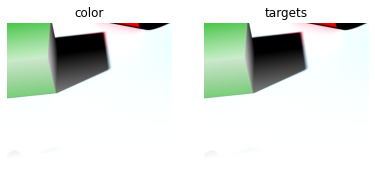

In [76]:
display_model_prediction(model, dataset[100]["x"])

In [70]:
dataset[0]["depth"].shape

torch.Size([1, 480, 480])

#WAndB

In [ ]:
!pip install wandb
!wandb login d940026e2002f5b8080f108f513ebc9214e48b44

     |████████████████████████████████| 1.8 MB 31.2 MB/s 
     |████████████████████████████████| 144 kB 67.1 MB/s 
     |████████████████████████████████| 181 kB 76.6 MB/s 
     |████████████████████████████████| 63 kB 2.1 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=70a76e6db2bb878b188a7fc6367897381fcb31cce0337e7b77a046cc3597b191
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
import wandb as wb

wb.init(
    project="mask-rcnn-fusion-experiments",
    name="test_run2"
)

In [ ]:
wb.finish()

In [ ]:
def log_loss_stats(loss_stats):
    wb.log({
        'loss_classifier':  loss_stats['loss_classifier'].item(), 
        'loss_box_reg':     loss_stats['loss_box_reg'].item(),
        'loss_mask':        loss_stats['loss_mask'].item(), 
        'loss_objectness':  loss_stats['loss_objectness'].item(), 
        'loss_rpn_box_reg': loss_stats['loss_rpn_box_reg'].item(),
        'loss_sum':         sum(loss for loss in loss_stats.values())
     })

In [ ]:
def log_figure(fig):
    pass

In [ ]:
def log_hyper_parameters(params):
    pass

# Training and Testing


training loop

In [71]:
def train(model, dataset, config):
    # read config values
    lr = config['lr']

    momentum = config["momentum"]
    gamma = config["gamma"]
    grad_clip = config['grad_clip']

    epochs = config["epochs"]
    batch_size = config['batch_size']

    verbose = config["verbose"]
    verbose_amount = config["verbose_amount"]
    print('will give loss readout')

    matplt = config["matplt"]
    matplt_amount = config["matplt_amount"]
    print('will show model progress')

    wandb = config["wandb"]
    wandb_amount = config["wandb_amount"]
    print('will save to wandb')

    checkpoints = config["checkpoints"]
    checkpoints_amount = config["checkpoints_amount"]
    print('will save checkpoints')

    model_name = config["model_name"]

    # prep data
    is_valid, train_data, test_data = train_test_split(dataset, percent_train=60)
    print(len(train_data), len(test_data))
    # make training objects
    train_dataloader = DataLoader(train_data, batch_size=1)
    test_dataloader  = DataLoader(test_data, batch_size=1)

    nSamples = [1000, 30, 5]
    normedWeights = [1 - (x / sum(nSamples)) for x in nSamples]
    normedWeights = torch.FloatTensor(normedWeights).to(device)
    print(normedWeights)

    criterion_weighted = CrossEntropyLoss(weight=normedWeights)

    optimizer = RMSprop(model.parameters(), lr=0.00001, momentum=momentum)
    scheduler = CosineAnnealingLR(optimizer, 10)

    # training loop  
    for epoch in range(epochs):
        print(f"\n\nSTARTING EPOCH {epoch}")
        epoch_loss = []
        # epoch_runtime = datetime.now()
        
        
        print(f"\n    STARTING TRAINING")
        model.train()
        for i, batch in enumerate(train_dataloader):
            # initialize inputs
            images = []
            targets = []
            
            for image_number in range(batch['x'].shape[0]):
                images.append(batch['x'][image_number].to(device=device).squeeze(0))
                
                # print("labels", batch["labels"][image_number].shape)
                # print("boxes", batch["boxes"][image_number].shape)
                # print("masks", batch["masks"][image_number].shape)

                targets.append({
                    "labels": batch["labels"][image_number].to(device=device),
                    "boxes": batch["boxes"][image_number].to(device=device),
                    "masks": batch["masks"][image_number].to(device=device)
                })

            
            # forward pass
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            epoch_loss.append(losses.item())


            # backpropagation
            optimizer.zero_grad()
            nn.utils.clip_grad_value_(model.parameters(), 0.001)
            losses.backward()
            optimizer.step()

            scheduler.step()

            # logging
            if verbose and i % verbose_amount == 0:
                print(f'\r        [{epoch}, {i}]: {losses:9.4f} VRAM:{(torch.cuda.memory_allocated(0)/1000000):9.3f}GB')
            else:
                print(f'\r        [{epoch}, {i}]: {losses:9.4f} VRAM:{(torch.cuda.memory_allocated(0)/1000000):9.3f}GB', end="")

            # if wandb and i % wandb_amount == 0:
            #   log_loss_stats(loss_dict)

        print(f"\n    FINISHED TRAINING")
        print(f"        avg loss per batch: {np.average(np.array(epoch_loss))}")
        print(f"        std loss per batch: {np.std(np.array(epoch_loss))}")

        # run validation every epoch
        test(model, test_dataloader, config)

        if matplt:
            # display sample
            display_model_prediction(model, dataset[0]["x"])

        # save model at checkpoints
        if checkpoints and epoch % checkpoints_amount == 1:
            save_model_parameters(SaveConfig({
                      'directory':'checkpoints',
                      'folder':f"{datetime.today().__str__()[:10]}_{RUNCODE}",
                      'name':f"{model_name}_{epoch}_{losses}"
                      }),
                      model,
                      optimizer)


    save_model_parameters(SaveConfig({
                'checkpoints',
                f"{datetime.today().__str__()[:10]}_{RUNCODE}",
                f"{model_name}_final_{0}"
                }),
              model,
              optimizer)

evaluation loop


In [72]:
def test(model, test_dataloader, config):
    # read config values
    batch_size = config['batch_size']

    verbose = config["verbose"]
    verbose_amount = config["verbose_amount"]

    matplt = config["matplt"]
    matplt_amount = config["matplt_amount"]

    wandb = config["wandb"]
    wandb_amount = config["wandb_amount"]

    model_name = config["model_name"]

    # make training objects

    criterion = CrossEntropyLoss(ignore_index=0)  # TODO: check this

    loss_record = []

    print(f"\n    STARTING VALIDATION")
    model.train()
    with torch.no_grad():
      for i, batch in enumerate(test_dataloader):

        # initialize inputs
        images = []
        targets = []

        for image_number in range(batch['x'].shape[0]):
            images.append(batch['x'][image_number].to(device=device).squeeze())

            targets.append({
                "labels": batch["labels"][image_number].to(device=device),
                "boxes": batch["boxes"][image_number].to(device=device),
                "masks": batch["masks"][image_number].to(device=device)
            })

        # forward pass
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        loss_record.append(losses.detach().cpu()) 

        # logging
        if verbose and i % verbose_amount == 0:
            print(f'\r        [val, {i}]: {losses:9.4f} VRAM:{(torch.cuda.memory_allocated(0)/1000000):9.3f}GB')
        else:
            print(f'\r        [val, {i}]: {losses:9.4f} VRAM:{(torch.cuda.memory_allocated(0)/1000000):9.3f}GB', end="")


      print(f"\n    FINISHED VALIDATION")
      print(f"        avg loss per batch: {np.average(np.array(loss_record))}")
      print(f"        std loss per batch: {np.std(np.array(loss_record))}")

        # if wandb and i % wandb_amount == 0:
        #   wb.log({
        #         'validation_loss': losses.item()
        #     })

# Benchmarks

#Experimentation

will give loss readout
will show model progress
will save to wandb
will save checkpoints
train fraction:  60.0
test fraction:  40.0
153 102
tensor([0.0338, 0.9710, 0.9952], device='cuda:0')


STARTING EPOCH 0

    STARTING TRAINING
        [0, 0]:    4.4942 VRAM:  610.383GB
        [0, 20]:    2.1002 VRAM:  605.554GB
        [0, 40]:    2.1616 VRAM:  610.383GB
        [0, 60]:    2.3925 VRAM:  640.575GB
        [0, 80]:    2.4652 VRAM:  605.554GB
        [0, 100]:    2.8091 VRAM:  605.554GB
        [0, 120]:    2.1489 VRAM:  605.554GB
        [0, 140]:    2.3243 VRAM:  605.554GB
        [0, 152]:    2.6556 VRAM:  605.554GB
    FINISHED TRAINING
        avg loss per batch: 2.3719729317559137
        std loss per batch: 0.5804831447064491

    STARTING VALIDATION
        [val, 0]:    1.7431 VRAM:  623.990GB
        [val, 20]:    1.8168 VRAM:  626.755GB
        [val, 40]:    2.1021 VRAM:  613.852GB
        [val, 60]:    2.5458 VRAM:  642.422GB
        [val, 80]:    2.3861 VRAM:  618.460GB

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


        [val, 101]:    4.0989 VRAM:  614.774GB
    FINISHED VALIDATION
        avg loss per batch: 2.360156536102295
        std loss per batch: 0.54793781042099
torch.Size([4, 480, 480])
boxes: torch.Size([1, 4])
labels: torch.Size([1])
scores: torch.Size([1])
masks: torch.Size([1, 1, 480, 480])


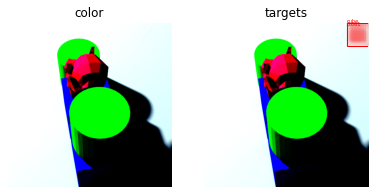



STARTING EPOCH 1

    STARTING TRAINING
        [1, 0]:    3.1311 VRAM:  610.383GB
        [1, 20]:    1.7987 VRAM:  605.554GB
        [1, 40]:    1.8996 VRAM:  610.383GB
        [1, 60]:    2.5318 VRAM:  640.575GB
        [1, 80]:    2.3352 VRAM:  605.554GB
        [1, 100]:    2.6492 VRAM:  605.554GB
        [1, 120]:    2.0165 VRAM:  605.554GB
        [1, 140]:    2.1063 VRAM:  605.554GB
        [1, 152]:    2.4180 VRAM:  605.554GB
    FINISHED TRAINING
        avg loss per batch: 2.3190869685092004
        std loss per batch: 0.5056359303465373

    STARTING VALIDATION
        [val, 0]:    2.3230 VRAM:  623.990GB
        [val, 20]:    3.7796 VRAM:  626.755GB
        [val, 40]:    1.9088 VRAM:  613.852GB
        [val, 60]:    4.2326 VRAM:  642.422GB
        [val, 80]:    3.1092 VRAM:  618.460GB
        [val, 100]:    3.0238 VRAM:  630.441GB
        [val, 101]:    4.1699 VRAM:  614.774GB
    FINISHED VALIDATION
        avg loss per batch: 2.8223373889923096
        std loss per bat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([4, 480, 480])
boxes: torch.Size([0, 4])
labels: torch.Size([0])
scores: torch.Size([0])
masks: torch.Size([0, 1, 480, 480])


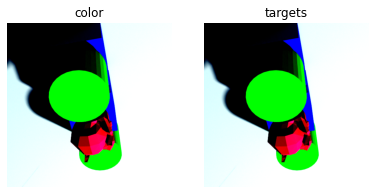

 checkpoints/2022-05-26_672788
saving checkpoint:
 checkpoints/2022-05-26_672788/unnamed_model_1_2.4179835319519043


STARTING EPOCH 2

    STARTING TRAINING
        [2, 0]:    2.7648 VRAM:  610.383GB
        [2, 20]:    1.7525 VRAM:  605.554GB
        [2, 40]:    2.0782 VRAM:  610.383GB
        [2, 60]:    3.7787 VRAM:  640.575GB
        [2, 73]:    3.2973 VRAM:  640.575GB

KeyboardInterrupt: ignored

In [73]:
model.cuda()
train_config = TrainingConfig({"matplt":True})
train(model, dataset, train_config)


In [49]:
display_model_prediction(model.cpu(), dataset[0]['x'].unsqueeze(0))

torch.Size([1, 4, 480, 480])


ValueError: ignored

In [48]:

save_model_parameters(SaveConfig({
          'directory':'checkpoints',
          'folder':f"{datetime.today().__str__()[:10]}_{RUNCODE}",
          'name':f"stock-model-final"
          }),
          model,
          RMSprop(params=model.parameters()))

saving checkpoint:
 checkpoints/2022-05-26_13545/stock-model-final
